# Churn Prediction

In [1]:
#import packages
import numpy as np
import pandas as pd
import itertools
import warnings
warnings.filterwarnings("ignore")

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
%matplotlib inline

## 1. Data

In [2]:
# import data as DataFrame
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
test_data["LEAVE"] = 0

# combine train and test together for manipulation
combined_train_test = train_data.append(test_data)

### 1.1 Data Overview

In [3]:
# train data overview
train_data.info()
print("-" * 40)
test_data.info()

#
print("\n\nRows     : " ,combined_train_test.shape[0])
print("Columns  : " ,combined_train_test.shape[1])
print("\nFeatures : \n" ,combined_train_test.columns.tolist())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 12 columns):
COLLEGE                        18000 non-null object
INCOME                         18000 non-null int64
OVERAGE                        18000 non-null int64
LEFTOVER                       18000 non-null int64
HOUSE                          18000 non-null int64
HANDSET_PRICE                  18000 non-null int64
OVER_15MINS_CALLS_PER_MONTH    18000 non-null int64
AVERAGE_CALL_DURATION          18000 non-null int64
REPORTED_SATISFACTION          18000 non-null object
REPORTED_USAGE_LEVEL           18000 non-null object
CONSIDERING_CHANGE_OF_PLAN     18000 non-null object
LEAVE                          18000 non-null int64
dtypes: int64(8), object(4)
memory usage: 1.6+ MB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 12 columns):
COLLEGE                        2000 non-null object
INCOME       

## 2. Data Manipulation

In [4]:
#construct bins for each feature to visulize data
train_data["AVERAGE_CALL_DURATION_BIN"] = pd.cut(train_data["AVERAGE_CALL_DURATION"],
                                                 bins = [0, 5, 10, 15],
                                                 labels = ["AVERAGE_CALL_DURATION_0-5",
                                                           "AVERAGE_CALL_DURATION_5-10",
                                                           "AVERAGE_CALL_DURATION_10-15"],
                                                 include_lowest = True)

train_data["OVER_15MIN_CALL_BIN"] = pd.cut(train_data["OVER_15MINS_CALLS_PER_MONTH"],
                                           bins = [0, 10, 20, 30],
                                           labels = ["OVER_15MINS_CALLS_PER_MONTH_0-10",
                                                     "OVER_15MINS_CALLS_PER_MONTH_10-20",
                                                     "OVER_15MINS_CALLS_PER_MONTH_20-30"],
                                           include_lowest = True)

train_data["INCOME_BIN"] = pd.cut(train_data["INCOME"],
                                  bins = [20000, 80000, 140000, 200000],
                                  labels = ["INCOME_20-80k",
                                            "INCOME_80k-140k",
                                            "INCOME_140k-200k"],
                                  include_lowest = True)

train_data["HOUSE_BIN"] = pd.cut(train_data["HOUSE"],
                                 bins = [150000, 400000, 700000, 1000000],
                                 labels = ["HOUSE_150-400k",
                                           "HOUSE_400k-700k",
                                           "HOUSE_700k-1m"],
                                 include_lowest = True)

train_data["OVERAGE_BIN"] = pd.cut(train_data["OVERAGE"],
                                   bins = [-3, 100, 250, 400],
                                   labels = ["OVERAGE_-3-150",
                                             "OVERAGE_150-250",
                                             "OVERAGE_250-400"],
                                   include_lowest = True)

train_data["LEFTOVER_BIN"] = pd.cut(train_data["LEFTOVER"],
                                    bins = [0, 33, 67, 100],
                                    labels = ["LEFTOVER_0-33",
                                              "LEFTOVER_33-67",
                                              "LEFTOVER_67-100"],
                                    include_lowest = True)

train_data["HANDSET_PRICE_BIN"] = pd.cut(train_data["HANDSET_PRICE"],
                                         bins = [100, 400, 700, 1000],
                                         labels = ["HANDSET_PRICE_100-400",
                                                   "HANDSET_PRICE_400-700",
                                                   "HANDSET_PRICE_700-1000"],
                                         include_lowest = True)

train_data["LEAVE"] = train_data["LEAVE"].replace({1:"Churn",0:"Not Churn"})

#separate leave and not leave
leave = train_data[train_data["LEAVE"] == "Churn"]
not_leave = train_data[train_data["LEAVE"] == "Not Churn"]

#Separating catagorical and numerical columns
target_col = ["LEAVE"]
cat_cols   = train_data.nunique()[train_data.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
num_cols   = [x for x in train_data.columns if x not in cat_cols + target_col]

## 3. Data Analysis

### 3.1 Churn Percentage in Data

In [5]:
#labels
lab = train_data["LEAVE"].value_counts().keys().tolist()
#values
val = train_data["LEAVE"].value_counts().values.tolist()

trace = go.Pie(labels = lab, values = val, rotation = 90, hoverinfo = "label+value+text", hole = .5)
layout = go.Layout(dict(title = "Percentage of Churn"))

data = [trace]
fig = go.Figure(data = data,layout = layout)
py.iplot(fig)

In [6]:
#function for pie plot
def plot_pie(column) :
    trace1 = go.Pie(values = leave[column].value_counts().values.tolist(),
                    labels = leave[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    domain = dict(x = [0,.48]), name = "Churn Customers", hole = .6)
    trace2 = go.Pie(values = not_leave[column].value_counts().values.tolist(),
                    labels = not_leave[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name", 
                    domain = dict(x = [.52,1]), name = "Not Churn Customers", hole = .6)
    layout = go.Layout(dict(title = column + "Distribution",
                            annotations = [dict(text = "Churn customers", font = dict(size = 13),
                                                showarrow = False, x = .17, y = .5),
                                           dict(text = "Not Churn customers", font = dict(size = 13),
                                                showarrow = False, x = .85, y = .5)]))
    data = [trace1,trace2]
    fig  = go.Figure(data = data,layout = layout)
    py.iplot(fig)
    
#function for histogram plot
def plot_hist(column) :
    trace1 = go.Histogram(x = leave[column], histnorm= "percent", name = "Churn Customers")  
    trace2 = go.Histogram(x = not_leave[column], histnorm = "percent", name = "Not Churn Customers")    
    data = [trace1,trace2]
    layout = go.Layout(dict(title = column + " Distribution",
                            xaxis = dict(gridcolor = 'rgb(50, 50, 50)', title = column,
                                         zerolinewidth=1, ticklen=5, gridwidth=2),
                            yaxis = dict(gridcolor = 'rgb(50, 50, 50)', title = "percent",
                                         zerolinewidth=1, ticklen=5, gridwidth=2),))
    fig  = go.Figure(data=data,layout=layout)
    py.iplot(fig)

### 3.2 Distribution in Categorical Features

In [7]:
# plotting categoriacal feature 
for i in cat_cols:
    plot_pie(i)

### 3.3 Distribution in Numerical Features

In [8]:
#
for j in num_cols:
    plot_hist(j)

## 4. Data Preprocessing

### 4.1 Data Preprocessing

In [9]:
# data preprocessing
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
# factorization
combined_train_test["COLLEGE"], _ = pd.factorize(combined_train_test["COLLEGE"])
combined_train_test["REPORTED_SATISFACTION"], _ = pd.factorize(combined_train_test["REPORTED_SATISFACTION"])
combined_train_test["REPORTED_USAGE_LEVEL"], _ = pd.factorize(combined_train_test["REPORTED_USAGE_LEVEL"])
combined_train_test["CONSIDERING_CHANGE_OF_PLAN"], _ = pd.factorize(combined_train_test["CONSIDERING_CHANGE_OF_PLAN"])
# data scaling
combined_train_test["INCOME"] = scaler.fit_transform(combined_train_test["INCOME"].values.reshape(-1, 1))
combined_train_test["OVERAGE"] = scaler.fit_transform(combined_train_test["OVERAGE"].values.reshape(-1, 1))
combined_train_test["LEFTOVER"] = scaler.fit_transform(combined_train_test["LEFTOVER"].values.reshape(-1, 1))
combined_train_test["HOUSE"] = scaler.fit_transform(combined_train_test["HOUSE"].values.reshape(-1, 1))
combined_train_test["HANDSET_PRICE"] = scaler.fit_transform(combined_train_test["HANDSET_PRICE"].values.reshape(-1, 1))
combined_train_test["OVER_15MINS_CALLS_PER_MONTH"] = scaler.fit_transform(combined_train_test["OVER_15MINS_CALLS_PER_MONTH"].values.reshape(-1, 1))
combined_train_test["AVERAGE_CALL_DURATION"] = scaler.fit_transform(combined_train_test["AVERAGE_CALL_DURATION"].values.reshape(-1, 1))
# data backup
combined_train_test_backup = combined_train_test

In [10]:
# do below if wrong operation happens
#combined_train_test = combined_train_test_backup

In [11]:
# separate data into train and test
train_data_scaled = combined_train_test[:18000]
test_data_scaled = combined_train_test[18000:]
X_train_df = train_data_scaled.drop(["LEAVE"], axis = 1)
Y_train_df = train_data_scaled["LEAVE"]
X_test_df = test_data_scaled.drop(["LEAVE"], axis = 1)

### 4.2 Feature Correlation

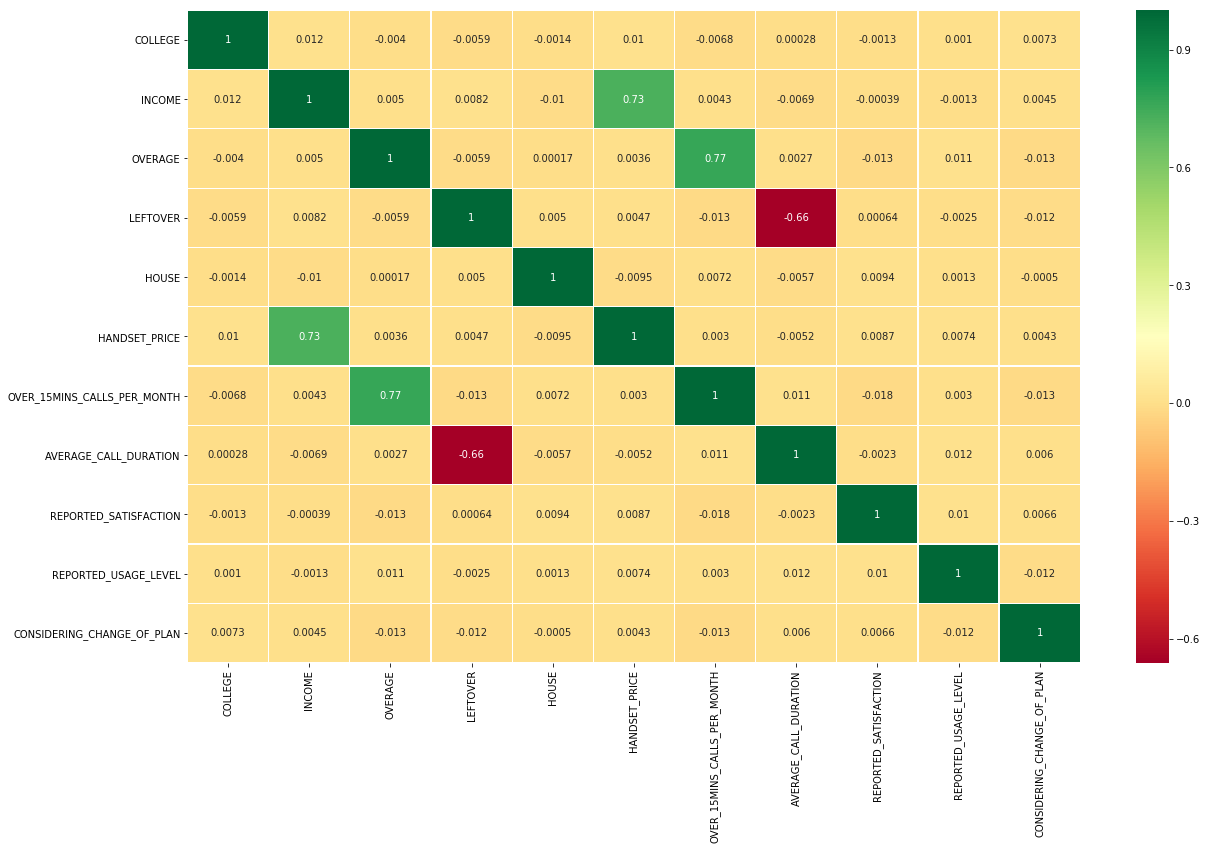

In [12]:
# plot feature correlation map
sns.heatmap(X_train_df.corr(),annot=True,cmap="RdYlGn",linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

### 4.3 Data Visualization in Principle Components

In [13]:
# decomposition
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
principal_components = pca.fit_transform(X_train_df)
pca_data = pd.DataFrame(principal_components, columns = ["PC1", "PC2"])
pca_data = pca_data.merge(Y_train_df, left_index=True, right_index=True, how="left")
pca_data["LEAVE"] = pca_data["LEAVE"].replace({1: "Churn", 0: "Not Churn"})

def pca_scatter(target,color) :
    tracer = go.Scatter(x = pca_data[pca_data["LEAVE"] == target]["PC1"],
                        y = pca_data[pca_data["LEAVE"] == target]["PC2"],
                        name = target, mode = "markers",
                        marker = dict(color = color, line = dict(width = .5), symbol =  "circle-open"))
    return tracer

trace1 = pca_scatter("Churn", "red")
trace2 = pca_scatter("Not Churn", "royalblue")

layout = go.Layout(dict(title = "Visualizing data with principal components",
                        xaxis = dict(gridcolor = "rgb(100, 100, 100)",
                                     title = "principal component 1",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = "rgb(100, 100, 100)",
                                     title = "principal component 2",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        height = 600))

data = [trace2,trace1]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

## 5. Model Performance

In [14]:
#
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score  
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import cross_val_predict 

In [15]:
#
from sklearn.model_selection import train_test_split

# separate train data into train set and validation set
x_train = X_train_df.values
y_train = Y_train_df.values
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size = 0.3, random_state = 220)

In [16]:
#
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score,recall_score

#
def model_performance(clf, x_train, y_train, x_test, y_test, col):
    
    columns = pd.DataFrame(X_train_df.columns)
    
    clf.fit(x_train, y_train)
    predictions = clf.predict(x_test)
    probabilities = clf.predict_proba(x_test)
    
    if col != None:
        if col == "a1":
            coe = pd.DataFrame(clf.coef_.ravel())
        elif col == "a2":
            coe = pd.DataFrame(clf.feature_importances_)
        feature_imp = (pd.merge(coe, columns,
                                left_index= True, right_index= True, how = "left"))
        feature_imp.columns = ["coefficients", "features"]
        feature_imp = feature_imp.sort_values(by = "coefficients", ascending = False)
    
    print("Classifier : \n", clf)
    print("\nClassification report : \n", classification_report(y_test, predictions))
    print("Accuracy   Score : ", accuracy_score(y_test, predictions))
    conf = confusion_matrix(y_test, predictions)
    model_roc_auc = roc_auc_score(y_test, probabilities[:,1]) 
    print("Area under curve : ", model_roc_auc, "\n")
    fpr, tpr, thresholds = roc_curve(y_test, probabilities[:,1])
    
    #plotting
    
    trace1 = go.Scatter(x = fpr, y = tpr, name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ("rgb(22, 96, 167)"), width = 2))
    trace2 = go.Scatter(x = [0,1], y=[0,1],
                        line = dict(color = ("rgb(205, 12, 24)"), width = 2, dash = 'dot'))
    trace3 = go.Heatmap(x = ["Not Leave", "Leave"], y = ["Not Leave", "Leave"], z = conf,
                        showscale  = False, colorscale = "Picnic", name = "matrix")
    if col != None:
        trace4 = go.Bar(x = feature_imp["features"], y = feature_imp["coefficients"],
                        name = "coefficients", marker = dict(color = feature_imp["coefficients"],
                                                             colorscale = "Picnic",
                                                             line = dict(width = .6,color = "black")))

    #subplots
    if col != None:
        fig = tls.make_subplots(rows = 2, cols = 2, subplot_titles = ("ROC Curve",
                                                                      "Confusion Matrix",
                                                                      "Feature Importance"))
        fig.append_trace(trace1, 1, 1)
        fig.append_trace(trace2, 1, 1)
        fig.append_trace(trace3, 1, 2)
        fig.append_trace(trace4, 2, 1)

        fig["layout"].update(showlegend = False, title = "Model performance", autosize = False, height = 900, width = 1000,
                             margin = dict(b = 195))
    else:
        fig = tls.make_subplots(rows = 1, cols = 2, subplot_titles = ("ROC Curve",
                                                                      "Confusion Matrix"))
        fig.append_trace(trace1, 1, 1)
        fig.append_trace(trace2, 1, 1)
        fig.append_trace(trace3, 1, 2)

        fig['layout'].update(showlegend = False, title = "Model performance", autosize = False, height = 550, width = 1000,
                             margin = dict(b = 195))
    fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))

    py.iplot(fig)
    return model_roc_auc

### 5.1 Logistic Regression

In [17]:
#
from sklearn.linear_model import LogisticRegression # Logistic Regression

lr = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                        intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=4,
                        penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
                        verbose=0, warm_start=False)

auc_lr = model_performance(lr, X_train, Y_train, X_test, Y_test, "a1")

Classifier : 
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=4,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Classification report : 
               precision    recall  f1-score   support

           0       0.65      0.67      0.66      2736
           1       0.65      0.63      0.64      2664

   micro avg       0.65      0.65      0.65      5400
   macro avg       0.65      0.65      0.65      5400
weighted avg       0.65      0.65      0.65      5400

Accuracy   Score :  0.6494444444444445
Area under curve :  0.6979731924907364 

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



### 5.2 Support Vector Machine

In [18]:
#
from sklearn import svm # Support Vector Machine

svc = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
              decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
              kernel='linear', max_iter=-1, probability=True, random_state=None,
              shrinking=True, tol=0.001, verbose=False)

auc_svc = model_performance(svc, X_train, Y_train, X_test, Y_test, "a1")

Classifier : 
 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Classification report : 
               precision    recall  f1-score   support

           0       0.63      0.71      0.67      2736
           1       0.66      0.57      0.61      2664

   micro avg       0.64      0.64      0.64      5400
   macro avg       0.64      0.64      0.64      5400
weighted avg       0.64      0.64      0.64      5400

Accuracy   Score :  0.6405555555555555
Area under curve :  0.6946742521029802 

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



### 5.3 KNN Classifier

In [19]:
#
from sklearn.neighbors import KNeighborsClassifier # KNN

knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                           metric_params=None, n_jobs=4, n_neighbors=4, p=2,
                           weights='uniform')

auc_knn = model_performance(knn, X_train, Y_train, X_test, Y_test, None)

Classifier : 
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=4, n_neighbors=4, p=2,
           weights='uniform')

Classification report : 
               precision    recall  f1-score   support

           0       0.60      0.77      0.68      2736
           1       0.67      0.47      0.55      2664

   micro avg       0.62      0.62      0.62      5400
   macro avg       0.63      0.62      0.61      5400
weighted avg       0.63      0.62      0.61      5400

Accuracy   Score :  0.6231481481481481
Area under curve :  0.664623162087526 

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



### 5.4 Decision Tree Classifier

In [20]:
#
from sklearn.tree import DecisionTreeClassifier # Decision Tree

dt = DecisionTreeClassifier(class_weight={0: 40., 1: 43.}, criterion='entropy', max_depth=8,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=1, min_samples_split=100,
                            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
                            splitter='best')

auc_dt = model_performance(dt, X_train, Y_train, X_test, Y_test, "a2")

Classifier : 
 DecisionTreeClassifier(class_weight={0: 40.0, 1: 43.0}, criterion='entropy',
            max_depth=8, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=100,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Classification report : 
               precision    recall  f1-score   support

           0       0.73      0.67      0.70      2736
           1       0.69      0.75      0.72      2664

   micro avg       0.71      0.71      0.71      5400
   macro avg       0.71      0.71      0.71      5400
weighted avg       0.71      0.71      0.71      5400

Accuracy   Score :  0.7066666666666667
Area under curve :  0.7668877759338286 

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



### 5.5 AdaBoost Classifier

In [21]:
#
from sklearn.ensemble import AdaBoostClassifier # AdaBoost

ada = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                         learning_rate=1, n_estimators=20, random_state=None)

auc_ada = model_performance(ada, X_train, Y_train, X_test, Y_test, "a2")

Classifier : 
 AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=20, random_state=None)

Classification report : 
               precision    recall  f1-score   support

           0       0.67      0.68      0.68      2736
           1       0.67      0.66      0.67      2664

   micro avg       0.67      0.67      0.67      5400
   macro avg       0.67      0.67      0.67      5400
weighted avg       0.67      0.67      0.67      5400

Accuracy   Score :  0.6718518518518518
Area under curve :  0.7301091524638673 

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



### 5.6 Gradient Boosting

In [22]:
#
from sklearn.ensemble import GradientBoostingClassifier # Gradient Boosting

gbc =  GradientBoostingClassifier(criterion='friedman_mse', init=None,
                                  learning_rate=0.05, loss='deviance', max_depth=4,
                                  max_features=0.3, max_leaf_nodes=None,
                                  min_impurity_decrease=0.0, min_impurity_split=None,
                                  min_samples_leaf=100, min_samples_split=2,
                                  min_weight_fraction_leaf=0.0, n_estimators=200,
                                  n_iter_no_change=None, presort='auto', random_state=None,
                                  subsample=1.0, tol=0.0001, validation_fraction=0.1,
                                  verbose=0, warm_start=False)

auc_gbc = model_performance(gbc, X_train, Y_train, X_test, Y_test, "a2")

Classifier : 
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=4,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=100, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

Classification report : 
               precision    recall  f1-score   support

           0       0.73      0.66      0.69      2736
           1       0.68      0.74      0.71      2664

   micro avg       0.70      0.70      0.70      5400
   macro avg       0.70      0.70      0.70      5400
weighted avg       0.70      0.70      0.70      5400

Accuracy   Score :  0.7025925925925925
Area under curve :  0.7743915790790791 

This

### 5.7 Xgboost Classifier

In [23]:
#
from xgboost import XGBClassifier #Xgboost

xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
                    max_depth=4, max_features=0.4, min_child_weight=1,
                    min_samples_leaf=10, missing=None, n_estimators=300, n_jobs=1,
                    nthread=None, objective='binary:logistic', random_state=10,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                    silent=True, subsample=1)
auc_xgb = model_performance(xgb, X_train, Y_train, X_test, Y_test, "a2")

Classifier : 
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=4, max_features=0.4, min_child_weight=1,
       min_samples_leaf=10, missing=None, n_estimators=300, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=10,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Classification report : 
               precision    recall  f1-score   support

           0       0.73      0.66      0.69      2736
           1       0.68      0.75      0.71      2664

   micro avg       0.70      0.70      0.70      5400
   macro avg       0.71      0.70      0.70      5400
weighted avg       0.71      0.70      0.70      5400

Accuracy   Score :  0.7044444444444444
Area under curve :  0.7744336304506261 

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



### 5.8 Random Forest Classifier

In [24]:
#
from sklearn.ensemble import RandomForestClassifier #Random Forest

rfc = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                             max_depth=4, max_features=0.4, max_leaf_nodes=None,
                             min_impurity_decrease=0.0, min_impurity_split=None,
                             min_samples_leaf=1, min_samples_split=10,
                             min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=None,
                             oob_score=False, random_state=None, verbose=0,
                             warm_start=False)

auc_rfc = model_performance(rfc, X_train, Y_train, X_test, Y_test, "a2")

Classifier : 
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features=0.4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Classification report : 
               precision    recall  f1-score   support

           0       0.68      0.77      0.72      2736
           1       0.72      0.63      0.68      2664

   micro avg       0.70      0.70      0.70      5400
   macro avg       0.70      0.70      0.70      5400
weighted avg       0.70      0.70      0.70      5400

Accuracy   Score :  0.6998148148148148
Area under curve :  0.7686185362994573 

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



### 5.9 Models Comparation

In [25]:
aucs = pd.DataFrame({'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
                               'Random Forest', 'AdaBoostClassifier', 'Gradient Boosting', 'Decision Tree', 'Xgboost'],
                     'Score': [auc_svc, auc_knn, auc_lr, auc_rfc, auc_ada, auc_gbc, auc_dt, auc_xgb]})
aucs.sort_values(by='Score',ascending=False)

Model     Score
7                  Xgboost  0.774434
5        Gradient Boosting  0.774392
3            Random Forest  0.768619
6            Decision Tree  0.766888
4       AdaBoostClassifier  0.730109
2      Logistic Regression  0.697973
0  Support Vector Machines  0.694674
1                      KNN  0.664623

Note: From the table above we can see that the top 4 model performs well in this data.

## 6. Hyperparameters Tuning

### 6.1 Tuning Parameters for Gradient Boosting Classifier

In [52]:
#
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier()
param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300,400],
              'learning_rate': [0.1, 0.05, 0.01,0.001],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.2,0.1] 
              }

modelf = GridSearchCV(model,param_grid = param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

modelf.fit(X_train,Y_train)

# Best score
print(modelf.best_score_)

# Best Estimator
modelf.best_estimator_

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   19.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  5.0min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  8.7min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 14.1min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed: 21.3min
[Parallel(n_jobs=4)]: Done 1920 out of 1920 | elapsed: 23.3min finished


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=4,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=100, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

### 6.2 Tuning Parameters for Xgboost Classifier

In [25]:
#
from sklearn.model_selection import GridSearchCV
model = XGBClassifier()
param_grid = {'n_estimators' : [100, 200, 300, 400],
              'learning_rate': [0.1, 0.05, 0.01,0.001],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.2, 0.1] 
              }

modelxgb = GridSearchCV(model,param_grid = param_grid, cv=7, scoring="accuracy", n_jobs= 4, verbose = 1)

modelxgb.fit(X_train,Y_train)

# Best score
print(modelxgb.best_score_)

# Best Estimator
modelxgb.best_estimator_

Fitting 7 folds for each of 192 candidates, totalling 1344 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   48.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  4.7min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 11.9min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 20.4min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 32.5min
[Parallel(n_jobs=4)]: Done 1344 out of 1344 | elapsed: 36.4min finished


0.7032539682539682


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=4, max_features=0.3, min_child_weight=1,
       min_samples_leaf=100, missing=None, n_estimators=300, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### 6.3 Tuning Parameters for Random Forest Classifier 

In [53]:
# Random Forest Classifier Parameters tunning 
model = RandomForestClassifier()
n_estim=range(100,1000,100)

## Search grid for optimal parameters
param_grid = {"n_estimators" :n_estim}

model_rf = GridSearchCV(model,param_grid = param_grid, cv=5, scoring="accuracy", n_jobs= 4, verbose = 1)

model_rf.fit(X_train,Y_train)

# Best score
print(model_rf.best_score_)

#best estimator
model_rf.best_estimator_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.8min finished


0.6524444444444445


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## 7. Model Ensembling

### 7.1 Stacking

In [59]:
from sklearn.model_selection import KFold
#
ntrain = X_train.shape[0]
ntest = X_test.shape[0]
kf = KFold(n_splits = 7, random_state=0, shuffle=False)
def get_fold(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain, 2))  
    oof_test = np.zeros((ntest, 2))
    oof_test_skf = np.empty((7, ntest))  
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        clf.fit(x_tr, y_tr)
        oof_train[test_index] = clf.predict_proba(x_te)
        oof_test += clf.predict_proba(x_test) 
    oof_test /= 7
    return oof_train, oof_test

In [60]:
# using optimal hyperparameters to construct model for layer 1
lr = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                        intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=4,
                        penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
                        verbose=0, warm_start=False)

svc = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
              decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
              kernel='rbf', max_iter=-1, probability=True, random_state=None,
              shrinking=True, tol=0.0001, verbose=False)

knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                           metric_params=None, n_jobs=4, n_neighbors=4, p=2,
                           weights='uniform')

dt = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
                            max_features=0.4, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=1, min_samples_split=10,
                            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
                            splitter='best')

ada = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                         learning_rate=1, n_estimators=20, random_state=None)

gbc =  GradientBoostingClassifier(criterion='friedman_mse', init=None,
                                  learning_rate=0.05, loss='deviance', max_depth=4,
                                  max_features=0.3, max_leaf_nodes=None,
                                  min_impurity_decrease=0.0, min_impurity_split=None,
                                  min_samples_leaf=100, min_samples_split=2,
                                  min_weight_fraction_leaf=0.0, n_estimators=200,
                                  n_iter_no_change=None, presort='auto', random_state=None,
                                  subsample=1.0, tol=0.0001, validation_fraction=0.1,
                                  verbose=0, warm_start=False)

rfc = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                             max_depth=None, max_features='auto', max_leaf_nodes=None,
                             min_impurity_decrease=0.0, min_impurity_split=None,
                             min_samples_leaf=1, min_samples_split=2,
                             min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=None,
                             oob_score=False, random_state=None, verbose=0,
                             warm_start=False)


In [61]:
#generate feature for layer 2
ada_xtrain, ada_xtest = get_fold(ada, X_train, Y_train, X_test)
#
lr_xtrain, lr_xtest = get_fold(lr, X_train, Y_train, X_test)
#
dt_xtrain, dt_xtest = get_fold(dt, X_train, Y_train, X_test)
#
gb_xtrain, gb_xtest = get_fold(gbc, X_train, Y_train, X_test)
#
kn_xtrain, kn_xtest = get_fold(knn, X_train, Y_train, X_test)
#
svc_xtrain, svc_xtest = get_fold(svc, X_train, Y_train, X_test)
#
rfc_xtrain, rfc_xtest = get_fold(rfc, X_train, Y_train, X_test)
#
xtrain = np.concatenate((ada_xtrain, lr_xtrain, dt_xtrain, gb_xtrain, kn_xtrain, svc_xtrain, rfc_xtrain), axis = 1)
xtest = np.concatenate((ada_xtest, lr_xtest, dt_xtest, gb_xtest, kn_xtest, svc_xtest, rfc_xtest), axis = 1)

X_train, X_test, Y_train, Y_test = train_test_split(xtrain, Y_train, test_size = 0.3, random_state = 220)

(12600, 14) (5400, 14)


In [64]:
# using xgboost classifier as layer-2 model
ult = XGBClassifier(base_score=0.5, booster="gbtree", colsample_bylevel=1,
                    colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
                    max_depth=4, max_features=0.3, min_child_weight=1,
                    min_samples_leaf=10, missing=None, n_estimators=300, n_jobs=1,
                    nthread=None, objective="binary:logistic", random_state=0,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                    silent=True, subsample=1)

auc_ult = model_performance(ult, X_train, Y_train, X_test, Y_test, None)

Classifier : 
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=4, max_features=0.3, min_child_weight=1,
       min_samples_leaf=10, missing=None, n_estimators=300, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Classification report : 
               precision    recall  f1-score   support

           0       0.74      0.65      0.69      2736
           1       0.68      0.76      0.72      2664

   micro avg       0.71      0.71      0.71      5400
   macro avg       0.71      0.71      0.70      5400
weighted avg       0.71      0.71      0.70      5400

Accuracy   Score :  0.7055555555555556
Area under curve :  0.7730579400672603 

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



## 8. Make Prediction

Finally, after trying different models and methods we decide to use decision tree classifier since it performs well on test data. The model ensembling seems to be overfitting so we decide to give it up.

In [26]:
# 
X_train = X_train_df.values
Y_train = Y_train_df.values
X_test = X_test_df.values

In [27]:
#
clf = DecisionTreeClassifier(class_weight={0: 40., 1: 43.}, criterion='entropy', max_depth=8,
                             max_features=None, max_leaf_nodes=None,
                             min_impurity_decrease=0.0, min_impurity_split=None,
                             min_samples_leaf=1, min_samples_split=100,
                             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
                             splitter='best')


clf.fit(X_train, Y_train)
pred = clf.predict_proba(X_test)
sol = clf.predict(X_test)

In [139]:
# store the prediction as .csv file
ID = np.arange(X_test.shape[0])
submission = pd.DataFrame({"LEAVE": pred[:, 1], "ID": ID})
submission.to_csv("submit13.csv", index = False, sep =",")